In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.contrib.learn.python.learn import monitors

# Load the datasets

In [2]:
FILE_PATH = "C:\\Users\\quanh\\Desktop\\datasets\\06\\driving_log.csv"
df = pd.read_csv(FILE_PATH,
                names=['center','left','right','steering','throttle','break','speed'], 
                header=None)

In [3]:
df.count()

center      14041
left        14041
right       14041
steering    14041
throttle    14041
break       14041
speed       14041
dtype: int64

# Preprocess the dataset

## Visualize the histogram of steering angle

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000165589FB8D0>]], dtype=object)

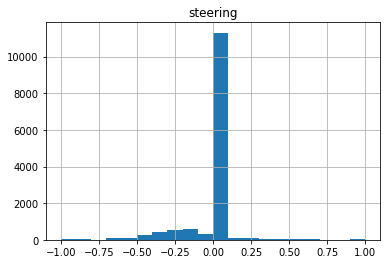

In [4]:
df.hist(column='steering', bins=20)

## Drop 95% of the 0 steering

In [5]:
df = df.drop(df.query('steering == 0').sample(frac=.95).index) # Drop 95% of 0 steering

## Visualize the final dataset

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001655905A978>]], dtype=object)

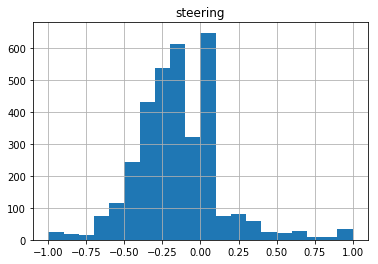

In [6]:
df.hist(column='steering', bins=20)

In [7]:
df.count()

center      3384
left        3384
right       3384
steering    3384
throttle    3384
break       3384
speed       3384
dtype: int64

# Prepare the dataset

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['center'], df['steering'], test_size=0.2)

In [9]:
train_data = X_train.tolist()
train_labels = y_train.tolist()
test_data = X_test.tolist()
test_labels = y_test.tolist()
print("Num of train data", len(train_data))
print("Num of test data", len(test_data))
print(train_data[10])
print(train_labels[10])

Num of train data 2707
Num of test data 677
C:\Users\quanh\Desktop\datasets\06\IMG\center_2018_01_21_15_01_39_192.jpg
-0.35


In [10]:
IMAGE_SIZE=64

# Create the input functions

In [11]:
def _parse_function(filename, label):
    with tf.device('/cpu:0'):
        image_string = tf.read_file(filename)
        image_decoded = tf.image.decode_jpeg(image_string)
    return image_decoded, label

def _preprocessing(image,label, is_training):
    with tf.device('/cpu:0'):
        image = tf.image.crop_to_bounding_box(image, 60, 0, 100, 320)
        if is_training:
#             image = tf.image.random_brightness(image, max_delta=0.35)
#             image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
#             image = tf.image.random_hue(image, max_delta=0.2)
#             image = tf.image.random_contrast(image, lower=0.5, upper=1.5)

            flip = tf.random_uniform([1], -1, 1)[0] > 0
            image = tf.cond(flip, lambda: tf.image.flip_left_right(image), lambda: image)
            label = tf.cond(flip, lambda: -label, lambda: label)
        image = tf.image.per_image_standardization(image)
    return image, label

In [12]:
def get_input_fn(list_data, list_labels, mode=tf.estimator.ModeKeys.EVAL, batch_size=64):
    def _input_fn():
        
        is_training = (mode == tf.estimator.ModeKeys.TRAIN)
        dataset = tf.data.Dataset.from_tensor_slices((list_data, list_labels)) 

        dataset = dataset.shuffle(buffer_size= 2 * batch_size + 1)
        
        dataset = dataset.map(_parse_function, num_parallel_calls=4)
        
        dataset = dataset.map(lambda image, label: (_preprocessing(image, label, is_training)), num_parallel_calls=8)
        
        dataset = dataset.prefetch(batch_size * 4 + 1)
        
        dataset = dataset.repeat()
        
        dataset = dataset.batch(batch_size)
        
        iterator = dataset.make_one_shot_iterator()
        
        images, labels = iterator.get_next()
        images = tf.image.resize_images(images, [IMAGE_SIZE, IMAGE_SIZE])
        features = {"x": images}
        return features, labels
        
    return _input_fn

In [13]:
train_input_fn = get_input_fn(train_data, train_labels, tf.estimator.ModeKeys.TRAIN)
test_input_fn = get_input_fn(test_data, test_labels, tf.estimator.ModeKeys.EVAL)

images_batch size (64, 64, 64, 3)
labels_batch size (64,)
labels_batch[0] -0.25


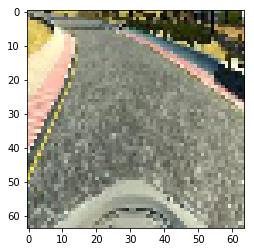

images_batch size (64, 64, 64, 3)
labels_batch size (64,)
labels_batch[0] 0.0


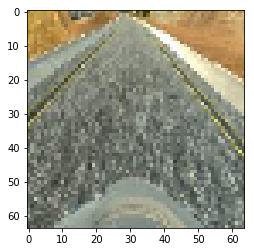

images_batch size (64, 64, 64, 3)
labels_batch size (64,)
labels_batch[0] 0.25


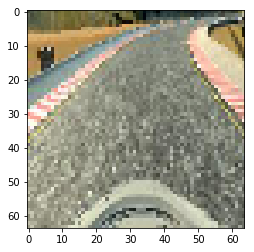

images_batch size (64, 64, 64, 3)
labels_batch size (64,)
labels_batch[0] -0.0


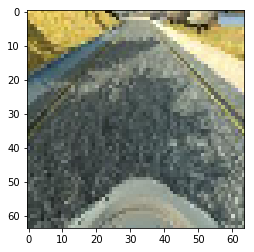

images_batch size (64, 64, 64, 3)
labels_batch size (64,)
labels_batch[0] 0.25


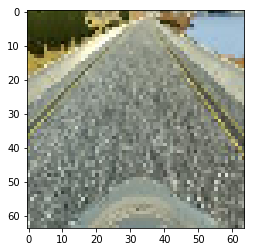

images_batch size (64, 64, 64, 3)
labels_batch size (64,)
labels_batch[0] -0.05


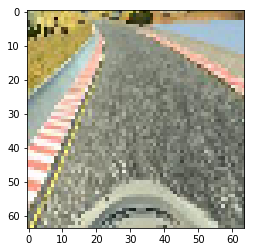

images_batch size (64, 64, 64, 3)
labels_batch size (64,)
labels_batch[0] -0.0985915


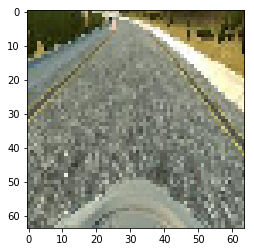

images_batch size (64, 64, 64, 3)
labels_batch size (64,)
labels_batch[0] 0.0


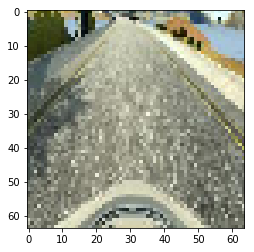

images_batch size (64, 64, 64, 3)
labels_batch size (64,)
labels_batch[0] -0.15


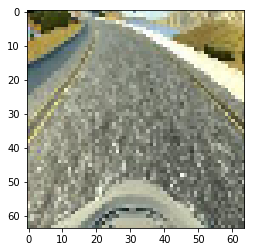

images_batch size (64, 64, 64, 3)
labels_batch size (64,)
labels_batch[0] 1.0


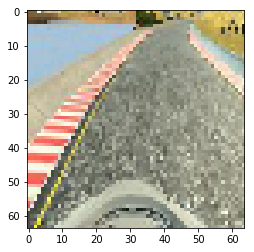

In [14]:
images, labels = train_input_fn()
with tf.Session() as sess:   
    for i in range(10):
        images_batch, labels_batch = sess.run([images, labels])
        print("images_batch size", images_batch['x'].shape)
        print("labels_batch size", labels_batch.shape)
        cur_image = images_batch['x'][0]
        print("labels_batch[0]", labels_batch[0])
        # Scale to 0, 1 for visualization
        cur_image = (cur_image - np.max(cur_image))/np.ptp(cur_image) + 1.0
        plt.imshow(cur_image.astype(np.float32))
        # Show the images_batch[0]
        # plt.imshow(images_batch[0])
        plt.show()

# Create model function

In [15]:
def my_model_fn(features, labels, mode):
    """Model function for our CNN"""
    
    net = tf.reshape(features['x'], [-1, IMAGE_SIZE, IMAGE_SIZE, 3])
    
    filters_size= [32, 64, 64, 128, 256]
    #filters_size= [32, 64, 128, 256]
    for i in range(len(filters_size)):
        net = tf.layers.conv2d(
            inputs=net,
            filters=filters_size[i],
            kernel_size=[3, 3],
            padding="same",
            activation=tf.nn.relu
        )
        net = tf.layers.batch_normalization(net, training=mode == tf.estimator.ModeKeys.TRAIN)
        net = tf.layers.max_pooling2d(
            inputs=net,
            pool_size=[2, 2],
            strides=[2,2]
        )        
    net = tf.layers.flatten(net)
    net = tf.layers.batch_normalization(net, training=mode == tf.estimator.ModeKeys.TRAIN)
    net = tf.layers.dropout(inputs=net, training=mode == tf.estimator.ModeKeys.TRAIN)
    net = tf.layers.dense(inputs=net, units=256)
#    net = tf.layers.batch_normalization(net, training=mode == tf.estimator.ModeKeys.TRAIN)
    net = tf.layers.dense(inputs=net, units=32)
#   net = tf.layers.batch_normalization(net, training=mode == tf.estimator.ModeKeys.TRAIN)
    logits = tf.layers.dense(inputs=net, units=1) # only steering angle
    output = tf.squeeze(logits)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            "output": output,
        }
        export_outputs = {
            'predictions': tf.estimator.export.PredictOutput(predictions)
        }
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions, export_outputs=export_outputs )
    
    rmse = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(labels, output))), name="rmse_tensor")
    tf.summary.scalar('rmse', rmse)
    
    loss = tf.losses.mean_squared_error(labels, output)
    
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
    
    eval_metric_ops = {
        "rmse": tf.metrics.root_mean_squared_error(labels, output)
    }
    return tf.estimator.EstimatorSpec(
        mode=mode, 
        loss=loss, 
        train_op=train_op,
        eval_metric_ops=eval_metric_ops)

In [16]:
my_estimator = tf.estimator.Estimator(
    model_fn=my_model_fn,
    model_dir="E:\\temp\\chapter_04\\v3"
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001655905AC18>, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_tf_random_seed': None, '_service': None, '_session_config': None, '_save_checkpoints_steps': None, '_task_type': 'worker', '_model_dir': 'E:\\temp\\chapter_04\\v3', '_is_chief': True, '_log_step_count_steps': 100, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}


In [21]:
tensors_to_log = {"rmse": "rmse_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=100)

train_spec = tf.estimator.TrainSpec(
    input_fn=train_input_fn,
    max_steps=35000,
    hooks=[logging_hook]
)

test_spec = tf.estimator.EvalSpec(
    input_fn=test_input_fn,
    steps=50, throttle_secs=60
)

In [22]:
tf.estimator.train_and_evaluate(my_estimator, train_spec, test_spec)

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 60 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from E:\temp\chapter_04\v3\model.ckpt-25000
INFO:tensorflow:Saving checkpoints for 25001 into E:\temp\chapter_04\v3\model.ckpt.
INFO:tensorflow:rmse = 0.0327149
INFO:tensorflow:loss = 0.00107027, step = 25001
INFO:tensorflow:global_step/sec: 19.0224
INFO:tensorflow:rmse = 0.0352703 (5.260 sec)
INFO:tensorflow:loss = 0.00124399, step = 25101 (5.260 sec)
INFO:tensorflow:global_step/sec: 19.2203
INFO:tensorflow:rmse = 0.0636799 (5.202 sec)
INFO:tensorflow:loss = 0.00405513, step = 25201 (5.202 sec)
INFO:tensorflow:global_step/sec: 18.2764
INFO:tensorflow:rmse = 0.0417126 (5.473 sec)
INFO:tensorflow:loss = 0.00173994, step = 25301 (5.473 sec)
INFO:tensorflow:global_step/sec: 18.3402
INFO:tensorflow:rms

INFO:tensorflow:rmse = 0.0712712
INFO:tensorflow:loss = 0.00507959, step = 27043
INFO:tensorflow:global_step/sec: 18.6735
INFO:tensorflow:rmse = 0.0632965 (5.356 sec)
INFO:tensorflow:loss = 0.00400645, step = 27143 (5.354 sec)
INFO:tensorflow:global_step/sec: 19.6947
INFO:tensorflow:rmse = 0.0367511 (5.077 sec)
INFO:tensorflow:loss = 0.00135064, step = 27243 (5.078 sec)
INFO:tensorflow:global_step/sec: 19.8161
INFO:tensorflow:rmse = 0.0354694 (5.049 sec)
INFO:tensorflow:loss = 0.00125808, step = 27343 (5.049 sec)
INFO:tensorflow:global_step/sec: 19.5749
INFO:tensorflow:rmse = 0.081181 (5.123 sec)
INFO:tensorflow:loss = 0.00659036, step = 27443 (5.123 sec)
INFO:tensorflow:global_step/sec: 19.5519
INFO:tensorflow:rmse = 0.0351322 (5.098 sec)
INFO:tensorflow:loss = 0.00123427, step = 27543 (5.098 sec)
INFO:tensorflow:global_step/sec: 18.8086
INFO:tensorflow:rmse = 0.0313727 (5.319 sec)
INFO:tensorflow:loss = 0.000984244, step = 27643 (5.318 sec)
INFO:tensorflow:global_step/sec: 19.0006
IN

INFO:tensorflow:global_step/sec: 19.9748
INFO:tensorflow:rmse = 0.0315632 (5.009 sec)
INFO:tensorflow:loss = 0.000996235, step = 29382 (5.009 sec)
INFO:tensorflow:global_step/sec: 19.6831
INFO:tensorflow:rmse = 0.0284321 (5.077 sec)
INFO:tensorflow:loss = 0.000808386, step = 29482 (5.077 sec)
INFO:tensorflow:global_step/sec: 19.8595
INFO:tensorflow:rmse = 0.0385402 (5.037 sec)
INFO:tensorflow:loss = 0.00148535, step = 29582 (5.036 sec)
INFO:tensorflow:global_step/sec: 19.8358
INFO:tensorflow:rmse = 0.0328984 (5.043 sec)
INFO:tensorflow:loss = 0.0010823, step = 29682 (5.045 sec)
INFO:tensorflow:global_step/sec: 19.5749
INFO:tensorflow:rmse = 0.0440845 (5.106 sec)
INFO:tensorflow:loss = 0.00194345, step = 29782 (5.104 sec)
INFO:tensorflow:global_step/sec: 19.8279
INFO:tensorflow:rmse = 0.037918 (5.044 sec)
INFO:tensorflow:loss = 0.00143778, step = 29882 (5.045 sec)
INFO:tensorflow:global_step/sec: 19.4527
INFO:tensorflow:rmse = 0.027757 (5.139 sec)
INFO:tensorflow:loss = 0.000770453, ste

INFO:tensorflow:loss = 0.000689745, step = 31684 (5.134 sec)
INFO:tensorflow:global_step/sec: 19.7611
INFO:tensorflow:rmse = 0.0348602 (5.065 sec)
INFO:tensorflow:loss = 0.00121523, step = 31784 (5.067 sec)
INFO:tensorflow:global_step/sec: 19.3809
INFO:tensorflow:rmse = 0.0383453 (5.155 sec)
INFO:tensorflow:loss = 0.00147037, step = 31884 (5.153 sec)
INFO:tensorflow:global_step/sec: 19.0296
INFO:tensorflow:rmse = 0.0327156 (5.257 sec)
INFO:tensorflow:loss = 0.00107031, step = 31984 (5.257 sec)
INFO:tensorflow:global_step/sec: 18.9681
INFO:tensorflow:rmse = 0.0829836 (5.275 sec)
INFO:tensorflow:loss = 0.00688627, step = 32084 (5.278 sec)
INFO:tensorflow:global_step/sec: 19.2055
INFO:tensorflow:rmse = 0.0510823 (5.202 sec)
INFO:tensorflow:loss = 0.00260941, step = 32184 (5.199 sec)
INFO:tensorflow:Saving checkpoints for 32223 into E:\temp\chapter_04\v3\model.ckpt.
INFO:tensorflow:Loss for final step: 0.00118429.
INFO:tensorflow:Starting evaluation at 2018-01-21-13:16:41
INFO:tensorflow:R

INFO:tensorflow:global_step/sec: 18.8462
INFO:tensorflow:rmse = 0.0392064 (5.306 sec)
INFO:tensorflow:loss = 0.00153714, step = 34071 (5.305 sec)
INFO:tensorflow:global_step/sec: 19.3171
INFO:tensorflow:rmse = 0.0339309 (5.180 sec)
INFO:tensorflow:loss = 0.00115131, step = 34171 (5.181 sec)
INFO:tensorflow:global_step/sec: 19.5175
INFO:tensorflow:rmse = 0.0345924 (5.122 sec)
INFO:tensorflow:loss = 0.00119663, step = 34271 (5.122 sec)
INFO:tensorflow:Saving checkpoints for 34290 into E:\temp\chapter_04\v3\model.ckpt.
INFO:tensorflow:Loss for final step: 0.00401034.
INFO:tensorflow:Starting evaluation at 2018-01-21-13:18:57
INFO:tensorflow:Restoring parameters from E:\temp\chapter_04\v3\model.ckpt-34290
INFO:tensorflow:Evaluation [1/50]
INFO:tensorflow:Evaluation [2/50]
INFO:tensorflow:Evaluation [3/50]
INFO:tensorflow:Evaluation [4/50]
INFO:tensorflow:Evaluation [5/50]
INFO:tensorflow:Evaluation [6/50]
INFO:tensorflow:Evaluation [7/50]
INFO:tensorflow:Evaluation [8/50]
INFO:tensorflow:E

# Export model

In [23]:
def preprocess_image(image):
    """Preprocess a single image of layout [height, width, depth]."""
    image = tf.image.crop_to_bounding_box(image, 60, 0, 100, 320)
    image = tf.image.per_image_standardization(image)
    images = tf.image.resize_images(tf.expand_dims(image, 0), [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.squeeze(images)
    return image

def serving_input_fn():
    receiver_tensor = {'images': tf.placeholder(shape=[None, 160, 320, 3], dtype=tf.float32)}
    features = {'x': tf.map_fn(preprocess_image, receiver_tensor['images'])}

    return tf.estimator.export.ServingInputReceiver(features, receiver_tensor)
my_estimator.export_savedmodel("E:\\temp\\chapter_04\\v3\\export", 
                               serving_input_receiver_fn=serving_input_fn,
                               checkpoint_path="E:\\temp\\chapter_04\\v3\\model.ckpt-35000"
                              )

INFO:tensorflow:Restoring parameters from E:\temp\chapter_04\v3\model.ckpt-35000
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b"E:\\temp\\chapter_04\\v3\\export\\temp-b'1516540917'\\saved_model.pb"


b'E:\\temp\\chapter_04\\v3\\export\\1516540917'

# Predict new sample

In [27]:
import os
export_dir = "E:\\temp\\chapter_04\\v1\\export"
saved_model_dir = os.path.join(export_dir, os.listdir(export_dir)[-1]) 
print(saved_model_dir)

E:\temp\chapter_04\v1\export\1516536229


In [29]:
predictor_fn = tf.contrib.predictor.from_saved_model(
  export_dir = saved_model_dir,
  signature_def_key='predictions')

INFO:tensorflow:Restoring parameters from b'E:\\temp\\chapter_04\\v1\\export\\1516536229\\variables\\variables'


In [32]:
import numpy as np
import cv2

predict_image = cv2.imread(test_data[0]).astype(np.float32)
predict_image = np.expand_dims(predict_image, axis=0)
print("predict_image", predict_image.shape)

predict_image (1, 160, 320, 3)


In [33]:
output = predictor_fn(
  {
    'images': predict_image,
  }
)
print(output)

{'output': -0.30280831}
